In [24]:
import numpy as np
import matplotlib.pyplot as plt
import re
from textwrap import wrap
import os
import json
color_list = [
    "cornflowerblue",
    "orange",
    "deeppink",
    "blueviolet",
    "seagreen",
    "black",
]
linestyle_list=["-","--","-.",":"]
from util.consts import get_base_delay_path,get_base_delay_transmission
def plot_cdf(
    raw_data,
    file_name,
    linelabels,
    x_label,
    y_label="CDF",
    log_switch=False,
    rotate_xaxis=False,
    ylim_low=0,
    xlim=None,
    xlim_bottom=None,
    fontsize=15,
    legend_font=15,
    loc=2,
    title=None,
    enable_abs=False,
    group_size=1,
):
    _fontsize = fontsize
    fig = plt.figure(figsize=(6, 4))  # 2.5 inch for 1/3 double column width
    ax = fig.add_subplot(111)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    if log_switch:
        ax.set_xscale("log")

    plt.ylabel(y_label, fontsize=_fontsize)
    plt.xlabel(x_label, fontsize=_fontsize)
    linelabels = ["\n".join(wrap(l, 30)) for l in linelabels]
    for i in range(len(raw_data)):
        data = raw_data[i]
        data = data[~np.isnan(data)]
        if len(data) == 0:
            continue
        if enable_abs:
            data = abs(data)
        # data=random.sample(data,min(1e6,len(data)))
        data_size = len(data)
        # data=list(filter(lambda score: 0<=score < std_val, data))
        # Set bins edges
        data_set = sorted(set(data))
        bins = np.append(data_set, data_set[-1] + 1)

        # Use the histogram function to bin the data
        counts, bin_edges = np.histogram(data, bins=bins, density=False)

        counts = counts.astype(float) / data_size

        # Find the cdf
        cdf = np.cumsum(counts)

        # Plot the cdf
        if i < len(linelabels):
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                label=linelabels[i],
                linewidth=3,
            )
        else:
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                linewidth=3,
            )

    legend_properties = {"size": legend_font}
    plt.legend(
        prop=legend_properties,
        frameon=False,
        loc=loc,
    )

    plt.ylim((ylim_low, 1))
    if xlim_bottom:
        plt.xlim(left=xlim_bottom)
    if xlim:
        plt.xlim(right=xlim)
    # plt.tight_layout()
    # plt.tight_layout(pad=0.5, w_pad=0.04, h_pad=0.01)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    # plt.grid(True)
    if rotate_xaxis:
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    if title:
        plt.title(title, fontsize=_fontsize - 5)
    # plt.savefig(file_name, bbox_inches="tight", pad_inches=0)

lr =10
UNIT_G=1e9
MTU=1000
labels = {
    0: "(0,1KB]",
    1: "(1KB,10KB]",
    2: "(10KB,50KB]",
    3: "(50KB,inf)",
}

3940
(3940, 4000)


/tmp/ipykernel_3756697/1110559853.py:60: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/data1/lichenni/software/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


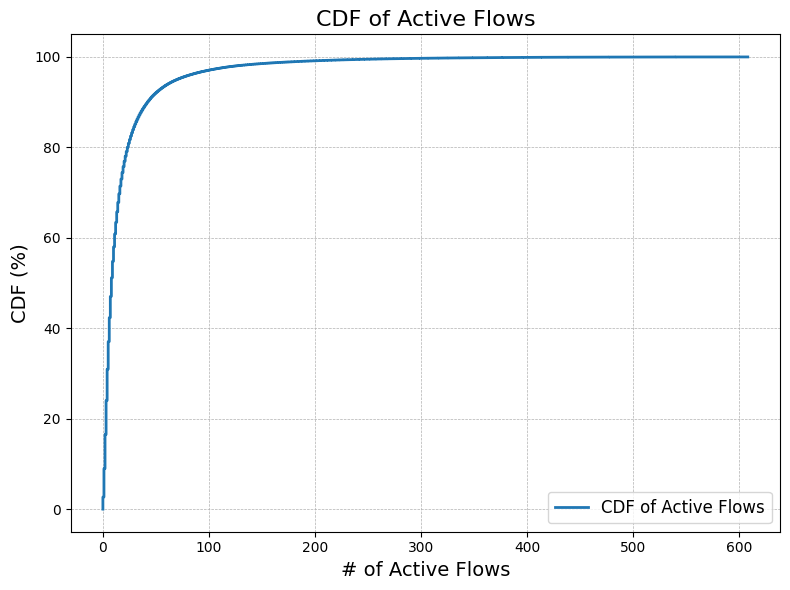

In [5]:

dir_input="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_train"
topo_type="_topology_flows"
data_list=[]
for shard in np.arange(4000):
    for n_flows in [2000]:
        for n_hosts in [32]:
            for sample in [0]:
                topo_type_cur=topo_type
                spec=f"{shard}/ns3"
                try:
                    fid = np.load(f"{dir_input}/{spec}/fid{topo_type_cur}.npy")
                    if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]) and len(fid)%n_flows==0:
                        data_list.append((spec,(0,n_hosts-1),topo_type_cur))
                    # else:
                    #     print(f"{spec}: {len(fid)}")
                except:
                    continue
               
print(len(data_list))

res_n_flows_active=[]
for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    dir_input_tmp = f"{dir_input}/{spec}"
    fat = np.load(f"{dir_input_tmp}/fat.npy")
    fct = fat+np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    
    arrival_events = np.column_stack((fat, np.ones_like(fat)))  # +1 for each arrival
    completion_events = np.column_stack((fct, -np.ones_like(fct)))  # -1 for each completion

    # Combine events and sort by time
    all_events = np.vstack((arrival_events, completion_events))
    all_events = all_events[all_events[:, 0].argsort()]  # Sort by time
    
    times = all_events[:, 0]
    flow_changes = all_events[:, 1]
    active_flows = np.cumsum(flow_changes)

    res_n_flows_active.append(active_flows)
   
res_n_flows_active=np.array(res_n_flows_active)
print(res_n_flows_active.shape)

# Combine all active flow counts across scenarios into one array
all_active_flows = np.concatenate(res_n_flows_active)

# Sort the active flow counts
sorted_flows = np.sort(all_active_flows)

# Compute the CDF
cdf = np.arange(1, len(sorted_flows) + 1) / len(sorted_flows)

# Plot the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_flows, cdf * 100, label='CDF of Active Flows', linewidth=2)
plt.xlabel('# of Active Flows over Time', fontsize=14)
plt.ylabel('CDF (%)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

94
(94, 160000)


/tmp/ipykernel_3756697/2951006326.py:56: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/data1/lichenni/software/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


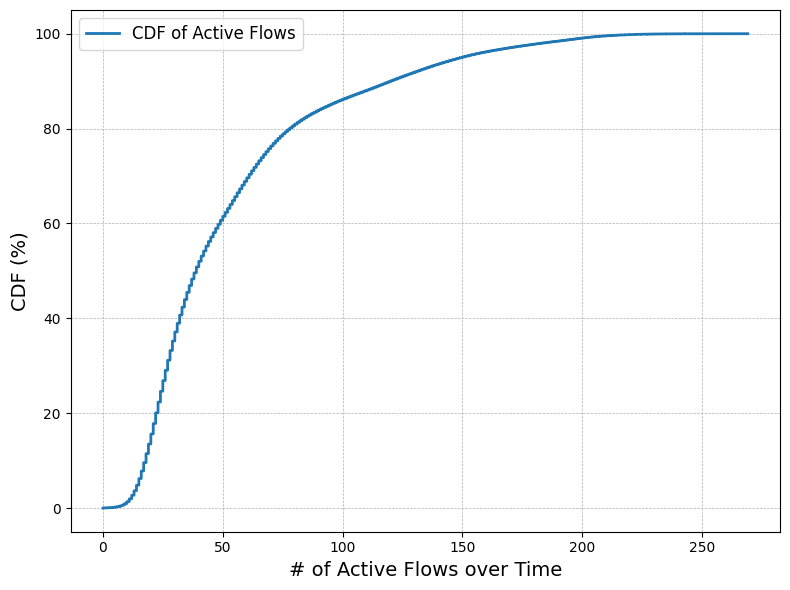

In [14]:

dir_input="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_test_8k"
n_flows=80000
topo_type="_topology_flows"
data_list=[]
for shard in np.arange(100):
    for n_hosts in [32]:
        spec=f"{shard}/ns3"
        fid_path=f"{dir_input}/{spec}/fid{topo_type}.npy"
        if os.path.exists(fid_path):
            fid = np.load(f"{dir_input}/{spec}/fid{topo_type}.npy")
            if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]):
                data_list.append((spec,(0,n_hosts-1),topo_type))
            # else:
            #     print(f"{spec}: {len(fid)}")
               
print(len(data_list))

res_n_flows_active=np.zeros((len(data_list),n_flows*2))
for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    dir_input_tmp = f"{dir_input}/{spec}"
    fat = np.load(f"{dir_input_tmp}/fat.npy")
    fct = fat+np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    
    arrival_events = np.column_stack((fat, np.ones_like(fat)))  # +1 for each arrival
    completion_events = np.column_stack((fct, -np.ones_like(fct)))  # -1 for each completion

    # Combine events and sort by time
    all_events = np.vstack((arrival_events, completion_events))
    all_events = all_events[all_events[:, 0].argsort()]  # Sort by time
    
    times = all_events[:, 0]
    flow_changes = all_events[:, 1]
    active_flows = np.cumsum(flow_changes)

    res_n_flows_active[spec_idx,:len(active_flows)]=active_flows
   
res_n_flows_active=np.array(res_n_flows_active)
print(res_n_flows_active.shape)

# Combine all active flow counts across scenarios into one array
all_active_flows = np.concatenate(res_n_flows_active)

# Sort the active flow counts
sorted_flows = np.sort(all_active_flows)

# Compute the CDF
cdf = np.arange(1, len(sorted_flows) + 1) / len(sorted_flows)

# Plot the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_flows, cdf * 100, label='CDF of Active Flows', linewidth=2)
plt.xlabel('# of Active Flows over Time', fontsize=14)
plt.ylabel('CDF (%)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

(171168,)
(1146400,)
(184556,)


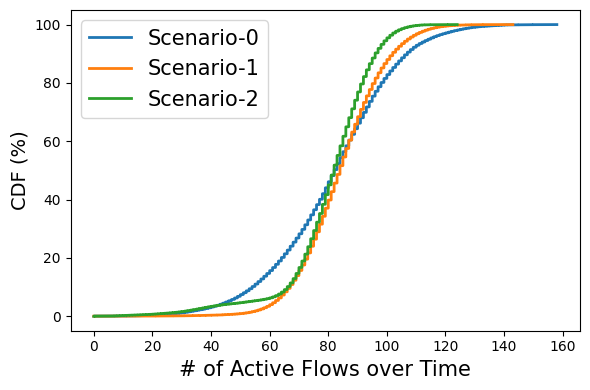

In [21]:

dir_input="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_7/data"
topo_type="_topology_flows"
res_n_flows_active=[]

# Plot the CDF
plt.figure(figsize=(6, 4))
for scenario_idx in range(3):
    dir_input_tmp = f"{dir_input}/{scenario_idx}/ns3"
    fat = np.load(f"{dir_input_tmp}/fat.npy")
    fct = fat+np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    
    arrival_events = np.column_stack((fat, np.ones_like(fat)))  # +1 for each arrival
    completion_events = np.column_stack((fct, -np.ones_like(fct)))  # -1 for each completion

    # Combine events and sort by time
    all_events = np.vstack((arrival_events, completion_events))
    all_events = all_events[all_events[:, 0].argsort()]  # Sort by time
    
    times = all_events[:, 0]
    flow_changes = all_events[:, 1]
    active_flows = np.cumsum(flow_changes)

    all_active_flows=np.array(active_flows)
    print(all_active_flows.shape)

    # Sort the active flow counts
    sorted_flows = np.sort(all_active_flows)

    # Compute the CDF
    cdf = np.arange(1, len(sorted_flows) + 1) / len(sorted_flows)
    
    plt.plot(sorted_flows, cdf * 100, label=f'Scenario-{scenario_idx}', linewidth=2)
plt.xlabel('# of Active Flows over Time', fontsize=15)
plt.ylabel('CDF (%)', fontsize=14)
# plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

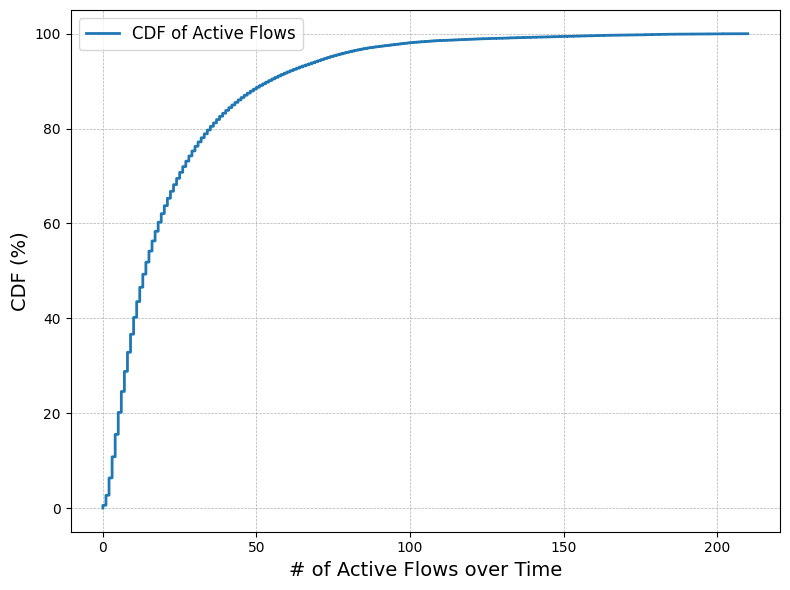

In [30]:

data_path="/data2/lichenni/output_perflow/final_param_shard4000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/data_list.json"
data_list=json.load(open(data_path))
data_list=data_list["train"]
flow_size_threshold=100000000
res_n_flows_active=[]
for spec_idx,(spec,src_dst_pair_target,topo_type,segment_id,_) in enumerate(data_list):
    dir_input_tmp = f"{dir_input}/{spec}"
    busy_periods=np.load(
        f"{dir_input_tmp}/period{topo_type}_t{flow_size_threshold}.npy",
        allow_pickle=True,
    )
    fid=np.array(busy_periods[segment_id])
    
    fat = np.load(f"{dir_input_tmp}/fat.npy")[fid]
    fct = fat+np.load(f'{dir_input_tmp}/fct{topo_type}.npy')[fid]
    
    arrival_events = np.column_stack((fat, np.ones_like(fat)))  # +1 for each arrival
    completion_events = np.column_stack((fct, -np.ones_like(fct)))  # -1 for each completion

    # Combine events and sort by time
    all_events = np.vstack((arrival_events, completion_events))
    all_events = all_events[all_events[:, 0].argsort()]  # Sort by time
    
    times = all_events[:, 0]
    flow_changes = all_events[:, 1]
    active_flows = np.cumsum(flow_changes)

    res_n_flows_active.append(active_flows)
   
# Combine all active flow counts across scenarios into one array
all_active_flows = np.concatenate(res_n_flows_active)

# Sort the active flow counts
sorted_flows = np.sort(all_active_flows)

# Compute the CDF
cdf = np.arange(1, len(sorted_flows) + 1) / len(sorted_flows)

# Plot the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_flows, cdf * 100, label='CDF of Active Flows', linewidth=2)
plt.xlabel('# of Active Flows over Time', fontsize=14)
plt.ylabel('CDF (%)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()